# Data Cleaning, Exploratory Data Analysis, and Hypothesis Testing

In this notebook we work with LinkedIn job postings and Google Trends data.  
Our goal is to clean the data, explore basic patterns, and then test if job demand (number of postings) is related to search interest for IT job titles.



**Step 1 – Keep only job titles from the raw data**

In this cell we load the original LinkedIn dataset `postings.csv` and keep only the `title` column.  
All other columns are dropped, because our analysis is based on job titles.  
We save this reduced file as `postings_title_time.csv` and use it in the next steps.


In [27]:
import pandas as pd

df = pd.read_csv(
    "postings.csv",
    usecols=["title"],
    engine="python",
    on_bad_lines="skip"   # skip nonsense columns
)

df.to_csv("postings_title_time.csv", index=False)

**Step 2 – Quick check of the job title data**

Here we print the first and last 5 rows of `postings_title_time.csv`.  
This is just a simple check to see how the raw job titles look before we start cleaning and grouping them.


In [28]:
# First 5 rows
print("First 5 rows:")
print(df.head())

# Last 5 rows
print("\nLast 5 rows:")
print(df.tail())

First 5 rows:
                                               title
0                              Marketing Coordinator
1                  Mental Health Therapist/Counselor
2                        Assitant Restaurant Manager
3  Senior Elder Law / Trusts and Estates Associat...
4                                 Service Technician

Last 5 rows:
                                               title
123844              Title IX/Investigations Attorney
123845  Staff Software Engineer, ML Serving Platform
123846          Account Executive, Oregon/Washington
123847                  Business Development Manager
123848             Marketing Social Media Specialist


**Step 3 – Clean titles and group them into IT job categories**

In this cell we first clean all job titles (lowercase, remove extra symbols and spaces).  
Then we use a keyword dictionary and the `map_it_role` function to assign each title to one IT role group (for example “software engineer”, “data analyst”, etc.).  
We print the counts for each group to see how many postings we have, and finally save the grouped data as `postings_it_grouped.csv` for later analysis.


In [29]:
import pandas as pd

#
# 1. Read CSV
#
# Change the file name below if needed
df = pd.read_csv(
    "postings_title_time.csv",
    usecols=["title"],
    engine="python",
    on_bad_lines="skip"
)

#
# 2. Normalize titles
#
df["title_clean"] = (
    df["title"]
      .astype(str)
      .str.lower()
      .str.replace(r"[\-/_,]", " ", regex=True)  # replace separators with space
      .str.replace(r"\s+", " ", regex=True)      # collapse multiple spaces
      .str.strip()
)

#
# 3. IT role groups and keyword lists
#    Keys are modern IT job titles for Google Trends
#
role_keywords = {
    "software engineer": [
        "software engineer", "software developer", "swe",
        "application developer", "applications developer",
        "applications engineer", "software prog", "software dev "
    ],
    "frontend developer": [
        "front end developer", "front-end developer", "frontend developer",
        "frontend engineer", "ui engineer", "ui developer",
        "javascript developer", "react developer", "angular developer",
        "vue developer"
    ],
    "backend developer": [
        "back end developer", "back-end developer", "backend developer",
        "backend engineer", "api developer", "server side developer"
    ],
    "full stack developer": [
        "full stack developer", "full-stack developer",
        "fullstack developer", "full stack engineer"
    ],
    "mobile developer": [
        "mobile developer", "android developer", "ios developer",
        "iphone developer", "mobile engineer"
    ],
    "data scientist": [
        "data scientist", "data science", "research scientist"
    ],
    "data analyst": [
        "data analyst", "data analytics", "business data analyst",
        "bi analyst", "business intelligence analyst"
    ],
    "machine learning engineer": [
        "machine learning engineer", "ml engineer", "ml ops",
        "mlops engineer"
    ],
    "devops engineer": [
        "devops engineer", "devops", "build engineer",
        "release engineer", "infrastructure engineer"
    ],
    "cloud engineer": [
        "cloud engineer", "cloud architect", "cloud specialist",
        "aws engineer", "azure engineer", "gcp engineer",
        "solutions architect"
    ],
    "qa engineer": [
        "qa engineer", "quality assurance engineer", "test engineer",
        "software tester", "sdet", "quality engineer"
    ],
    "security engineer": [
        "security engineer", "application security", "appsec",
        "cyber security", "cybersecurity", "infosec",
        "information security"
    ],
    "database administrator": [
        "database administrator", "dba", "database engineer", "sql dba"
    ],
    "network / systems administrator": [
        "system administrator", "systems administrator", "systems admin",
        "sysadmin", "network administrator", "network engineer",
        "it administrator"
    ],
    "it support specialist": [
        "it support", "help desk", "service desk",
        "desktop support", "technical support"
    ],
    "business analyst (it)": [
        "business analyst", "systems analyst", "it analyst"
    ],
    "product manager (tech)": [
        "product manager", "technical product manager", "product owner"
    ],
    "project manager (it)": [
        "project manager", "scrum master", "agile coach",
        "it project manager"
    ],
    "ux / ui designer": [
        "ux designer", "ui designer", "product designer",
        "interaction designer", "experience designer"
    ],
    "engineering manager / tech lead": [
        "engineering manager", "software development manager",
        "tech lead", "technical lead", "team lead"
    ],
    "other it": [
        "it specialist", "it engineer", "it consultant",
        "technology consultant", "technical consultant"
    ],
}

#
# 4. Function to map a title to an IT role group
#
def map_it_role(clean_title: str) -> str:
    if not isinstance(clean_title, str) or clean_title == "":
        return "non-it / unknown"

    t = clean_title

    # Exact-ish keyword-based mapping
    for role, keywords in role_keywords.items():
        for kw in keywords:
            if kw in t:
                return role

    # Generic fallback rules
    if "developer" in t or "software engineer" in t:
        return "software engineer"
    if "engineer" in t and "data" in t:
        return "data scientist"
    if "engineer" in t and "cloud" in t:
        return "cloud engineer"
    if "support" in t and ("it" in t or "tech" in t or "technical" in t):
        return "it support specialist"

    return "non-it / unknown"

#
# 5. Apply mapping
#
df["it_role_group"] = df["title_clean"].apply(map_it_role)

#
# 6. Inspect group counts
#
print("All groups (including non-IT):")
print(df["it_role_group"].value_counts().head(30))

print("\nIT-focused groups only:")
print(df.loc[df["it_role_group"] != "non-it / unknown", "it_role_group"].value_counts())

#
# 7. Save result
#
df.to_csv("postings_it_grouped.csv", index=False)

df.head()


All groups (including non-IT):
it_role_group
non-it / unknown                   110217
software engineer                    3578
project manager (it)                 2085
data scientist                        889
it support specialist                 833
business analyst (it)                 744
engineering manager / tech lead       729
product manager (tech)                659
qa engineer                           573
network / systems administrator       554
security engineer                     539
data analyst                          488
cloud engineer                        355
devops engineer                       348
full stack developer                  231
database administrator                225
frontend developer                    199
ux / ui designer                      198
backend developer                     124
machine learning engineer             110
other it                               97
mobile developer                       74
Name: count, dtype: int64

IT-f

,title,title_clean,it_role_group
0,Marketing Coordinator,marketing coordinator,non-it / unknown
1,Mental Health Therapist/Counselor,mental health therapist counselor,non-it / unknown
2,Assitant Restaurant Manager,assitant restaurant manager,non-it / unknown
3,Senior Elder Law / Trusts and Estates Associat...,senior elder law trusts and estates associate ...,non-it / unknown
4,Service Technician,service technician,non-it / unknown


**Step 4 – Count job postings for each IT role group**

Here we load the grouped dataset and remove all rows that are marked as “non-it / unknown”.  
For the remaining IT roles, we count how many job postings belong to each role group.  
These counts are saved as `it_role_group_counts.csv`, which we later compare with Google Trends interest.


In [30]:
import pandas as pd

# 1. Read the grouped file
#    (created in the previous step)
df = pd.read_csv("postings_it_grouped.csv")

# 2. Keep only IT-related groups (drop non-it / unknown)
mask_it = df["it_role_group"] != "non-it / unknown"

# 3. Count how many rows each IT group has
it_counts = (
    df.loc[mask_it, "it_role_group"]
      .value_counts()
      .reset_index()
)

# Rename columns
it_counts.columns = ["it_role_group", "count"]

# 4. Save to a new CSV
it_counts.to_csv("it_role_group_counts.csv", index=False)

# 5. Optional: show result
print(it_counts)


                      it_role_group  count
0                 software engineer   3578
1              project manager (it)   2085
2                    data scientist    889
3             it support specialist    833
4             business analyst (it)    744
5   engineering manager / tech lead    729
6            product manager (tech)    659
7                       qa engineer    573
8   network / systems administrator    554
9                 security engineer    539
10                     data analyst    488
11                   cloud engineer    355
12                  devops engineer    348
13             full stack developer    231
14           database administrator    225
15               frontend developer    199
16                 ux / ui designer    198
17                backend developer    124
18        machine learning engineer    110
19                         other it     97
20                 mobile developer     74


**Step 5 – Collect Google Trends data for each IT role**

In this cell we connect to Google Trends using `pytrends` and use our 20 IT role groups as search terms.  
For each role we download interest over time between **2023-01-01 and 2024-04-30** (worldwide). The time period is specificly selected to have a complete alignment with the Linkedin data from Kaggle.
We merge all batches into one table (wide format) and also create a tidy long format with columns `date`, `job_group`, and `trends_interest`.  
Both versions are saved as CSV files for later aggregation and comparison with LinkedIn data.


In [31]:
#
# 0. Install pytrends (run once per runtime)
#
!pip install pytrends --quiet

import pandas as pd
from pytrends.request import TrendReq
from functools import reduce

#
# 1. Define job groups and corresponding search terms
#
trends_terms = {
    "software engineer": "software engineer",
    "frontend developer": "front end developer",
    "backend developer": "back end developer",
    "full stack developer": "full stack developer",
    "mobile developer": "mobile app developer",
    "data scientist": "data scientist",
    "data analyst": "data analyst",
    "machine learning engineer": "machine learning engineer",
    "devops engineer": "devops engineer",
    "cloud engineer": "cloud engineer",
    "qa engineer": "qa engineer",
    "security engineer": "cyber security engineer",
    "database administrator": "database administrator",
    "network / systems administrator": "system administrator",
    "it support specialist": "it support specialist",
    "business analyst (it)": "it business analyst",
    "product manager (tech)": "product manager",
    "project manager (it)": "it project manager",
    "ux / ui designer": "ux designer",
    "engineering manager / tech lead": "engineering manager",
}

job_groups = list(trends_terms.keys())

#
# 2. Google Trends parameters
#
# GEO: "" = worldwide, "TR" = Turkey, "US" = United States, etc.
GEO = ""  # change to "TR" if you want Turkey-specific interest

# Timeframe is EXACTLY 2023-01-01 to 2024-04-30
TIMEFRAME = "2023-01-01 2024-04-30"

pytrends = TrendReq(hl="en-US", tz=0)

# Helper to split list into chunks of max size n (Google Trends allows max 5 terms)
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#
# 3. Fetch Google Trends data in batches of 5 terms
#
all_dfs = []

for group_batch in chunk_list(job_groups, 5):
    kw_list = [trends_terms[g] for g in group_batch]

    # Build payload for this batch
    pytrends.build_payload(
        kw_list=kw_list,
        geo=GEO,
        timeframe=TIMEFRAME
    )

    batch_df = pytrends.interest_over_time()

    if batch_df.empty:
        print(f"No data returned for batch: {group_batch}")
        continue

    # Drop isPartial column if present
    if "isPartial" in batch_df.columns:
        batch_df = batch_df.drop(columns=["isPartial"])

    # Rename columns from search terms to job group names
    rename_map = {trends_terms[g]: g for g in group_batch}
    batch_df = batch_df.rename(columns=rename_map)

    all_dfs.append(batch_df)

#
# 4. Merge all batches into a single wide DataFrame
#
if not all_dfs:
    raise ValueError("No data fetched from Google Trends. Check GEO/timeframe/connection.")

trends_wide = reduce(lambda left, right: left.join(right, how="outer"), all_dfs)

# Ensure we only keep data strictly within the timeframe (safety check)
trends_wide = trends_wide.loc[
    (trends_wide.index >= "2023-01-01") &
    (trends_wide.index <= "2024-04-30")
]

# Reset index so 'date' becomes a column
trends_wide = trends_wide.reset_index()
trends_wide.rename(columns={"date": "date"}, inplace=True)

#
# 5. Also create a long (tidy) version: date | job_group | trends_interest
#
trends_long = trends_wide.melt(
    id_vars="date",
    var_name="job_group",
    value_name="trends_interest"
)

#
# 6. Save to CSV files
#
trends_wide.to_csv("google_trends_it_jobs_wide.csv", index=False)
trends_long.to_csv("google_trends_it_jobs_long.csv", index=False)

print("Wide format (first rows):")
print(trends_wide.head())

print("\nLong format (first rows):")
print(trends_long.head())


Wide format (first rows):
        date  software engineer  frontend developer  backend developer  \
0 2023-01-01                 73                  12                  2   
1 2023-01-08                 81                  12                  2   
2 2023-01-15                 75                  12                  2   
3 2023-01-22                 80                  12                  2   
4 2023-01-29                 78                  12                  2   

   full stack developer  mobile developer  data scientist  data analyst  \
0                    17                 1              39            80   
1                    17                 1              39            84   
2                    16                 1              42            86   
3                    18                 1              41            86   
4                    17                 1              43            86   

   machine learning engineer  devops engineer  ...  qa engineer  \
0          

**Step 6 – Aggregate Google Trends interest for each IT role**

In this cell we work with the long-format Google Trends data.  
First, we fill any missing `trends_interest` values with 0.  
Then we sum the interest scores over time for each `job_group` to get one total value per IT role.  
We also add the `search_term` column using the same mapping we used when calling Google Trends.  
Finally, we save this aggregated dataset as `google_trends_it_jobs_totals.csv`, which now has no date column and is ready to compare with LinkedIn job posting counts.


In [32]:
import pandas as pd

#
# 1. Read Google Trends long-format data
#    (created previously)
#
trends_long = pd.read_csv("google_trends_it_jobs_long.csv")

#
# 2. Define mapping: job_group -> search term
#    (same as used when fetching Trends)
#
trends_terms = {
    "software engineer": "software engineer",
    "frontend developer": "front end developer",
    "backend developer": "back end developer",
    "full stack developer": "full stack developer",
    "mobile developer": "mobile app developer",
    "data scientist": "data scientist",
    "data analyst": "data analyst",
    "machine learning engineer": "machine learning engineer",
    "devops engineer": "devops engineer",
    "cloud engineer": "cloud engineer",
    "qa engineer": "qa engineer",
    "security engineer": "cyber security engineer",
    "database administrator": "database administrator",
    "network / systems administrator": "system administrator",
    "it support specialist": "it support specialist",
    "business analyst (it)": "it business analyst",
    "product manager (tech)": "product manager",
    "project manager (it)": "it project manager",
    "ux / ui designer": "ux designer",
    "engineering manager / tech lead": "engineering manager",
}

#
# 3. Aggregate: total Trends interest per job_group
#
# Remove possible NaNs just in case
trends_long["trends_interest"] = trends_long["trends_interest"].fillna(0)

trends_total = (
    trends_long
    .groupby("job_group", as_index=False)["trends_interest"]
    .sum()
)

trends_total = trends_total.rename(columns={"trends_interest": "total_trends_interest"})

#
# 4. Add search_term column using mapping
#
trends_total["search_term"] = trends_total["job_group"].map(trends_terms)

# Optional: keep only job groups that exist in the mapping
trends_total = trends_total[trends_total["search_term"].notna()]

# Reorder columns
trends_total = trends_total[["job_group", "search_term", "total_trends_interest"]]

#
# 5. Save to CSV (no date column)
#
output_filename = "google_trends_it_jobs_totals.csv"
trends_total.to_csv(output_filename, index=False)

print(f"Saved aggregated Trends data to: {output_filename}")
print(trends_total.head(21))


Saved aggregated Trends data to: google_trends_it_jobs_totals.csv
                          job_group                search_term  \
0                 backend developer         back end developer   
1             business analyst (it)        it business analyst   
2                    cloud engineer             cloud engineer   
3                      data analyst               data analyst   
4                    data scientist             data scientist   
5            database administrator     database administrator   
6                   devops engineer            devops engineer   
7   engineering manager / tech lead        engineering manager   
8                frontend developer        front end developer   
9              full stack developer       full stack developer   
10            it support specialist      it support specialist   
11        machine learning engineer  machine learning engineer   
12                 mobile developer       mobile app developer   
13  networ

**Step 7 – Sort IT roles by total Google search interest**

Here we load the aggregated Google Trends totals and sort the IT roles by `total_trends_interest` in descending order.  
This gives us a ranking of which IT job groups have the highest overall search interest.  
We save the sorted result as `google_trends_it_jobs_totals_sorted.csv` and print the top roles.


In [33]:
import pandas as pd

# 1. Read the existing CSV
df_trends = pd.read_csv("google_trends_it_jobs_totals.csv")

# 2. Sort by total_trends_interest in descending order
df_trends_sorted = df_trends.sort_values(
    by="total_trends_interest",
    ascending=False
)

# 3. Save back to a new CSV (or overwrite if you prefer)
df_trends_sorted.to_csv(
    "google_trends_it_jobs_totals_sorted.csv",
    index=False
)

# 4. Quick preview
df_trends_sorted.head(21)


,job_group,search_term,total_trends_interest
3,data analyst,data analyst,6164
13,network / systems administrator,system administrator,5774
14,product manager (tech),product manager,5511
18,software engineer,software engineer,5339
16,qa engineer,qa engineer,3187
4,data scientist,data scientist,2676
19,ux / ui designer,ux designer,2557
5,database administrator,database administrator,2262
17,security engineer,cyber security engineer,1426
7,engineering manager / tech lead,engineering manager,1355


**Step 8 – Test the relationship between job postings and search interest**

In this cell we merge the LinkedIn dataset (`it_role_group_counts.csv`) with the Google Trends dataset (`google_trends_it_jobs_totals_sorted.csv`) using the IT role names.  
Then we calculate the **Spearman rank correlation** between `count` (number of LinkedIn job postings) and `total_trends_interest` (total Google search interest).  
The output gives us the Spearman correlation coefficient (ρ) and the p-value, which we use for our hypothesis test about the relationship between job demand and search interest.


In [34]:
import pandas as pd
from scipy.stats import spearmanr

# Load both datasets
linkedin = pd.read_csv("it_role_group_counts.csv")
trends = pd.read_csv("google_trends_it_jobs_totals_sorted.csv")

# Merge by role/group
merged = pd.merge(
    linkedin,
    trends,
    left_on="it_role_group",
    right_on="job_group",
    how="inner"
)

# Spearman rank correlation
rho, p_value = spearmanr(
    merged["count"],
    merged["total_trends_interest"]
)

print("Spearman correlation coefficient (ρ):", round(rho, 3))
print("p-value:", round(p_value, 4))


Spearman correlation coefficient (ρ): 0.45
p-value: 0.0467


**RESULT – Hypothesis testing with Spearman rank correlation**

In this cell we perform our main hypothesis test about the relationship between Google search interest and LinkedIn job demand.  
We merge the two datasets by IT role group and then calculate the **Spearman rank correlation** between:

- `count` → number of LinkedIn job postings  
- `total_trends_interest` → total Google search interest for the same role  

We test the following hypotheses:

- **Null Hypothesis (H₀):**  
  There is no statistically significant relationship between the Google search volume of IT job-related keywords and the number of corresponding IT job postings on LinkedIn across different IT role groups.

- **Alternative Hypothesis (H₁):**  
  There is a statistically significant relationship between the Google search volume of IT job-related keywords and the number of corresponding IT job postings on LinkedIn across different IT role groups.

Using a significance level of **α = 0.05**, the Spearman test returns a correlation coefficient (ρ) of around **0.45** with **p < 0.05**.  
Therefore, we **reject H₀** and accept H₁: our results support a statistically significant positive relationship between Google search interest and LinkedIn job postings across IT roles.


**Step 9 – Visualize and compare LinkedIn demand and Google search interest**

In this cell we first create two bar charts:  
- one for the number of LinkedIn job postings by IT role group,  
- and one for the total Google Trends interest by IT role group.

Then we merge the two datasets and calculate ranks for each role based on LinkedIn counts and Google Trends interest (rank 1 = highest).  
We compute the rank difference for each role and save the result as `job_group_rank_comparison.csv`.  
This helps us see which IT roles have similar positions in both rankings and which roles show the biggest mismatch between job demand and search interest.


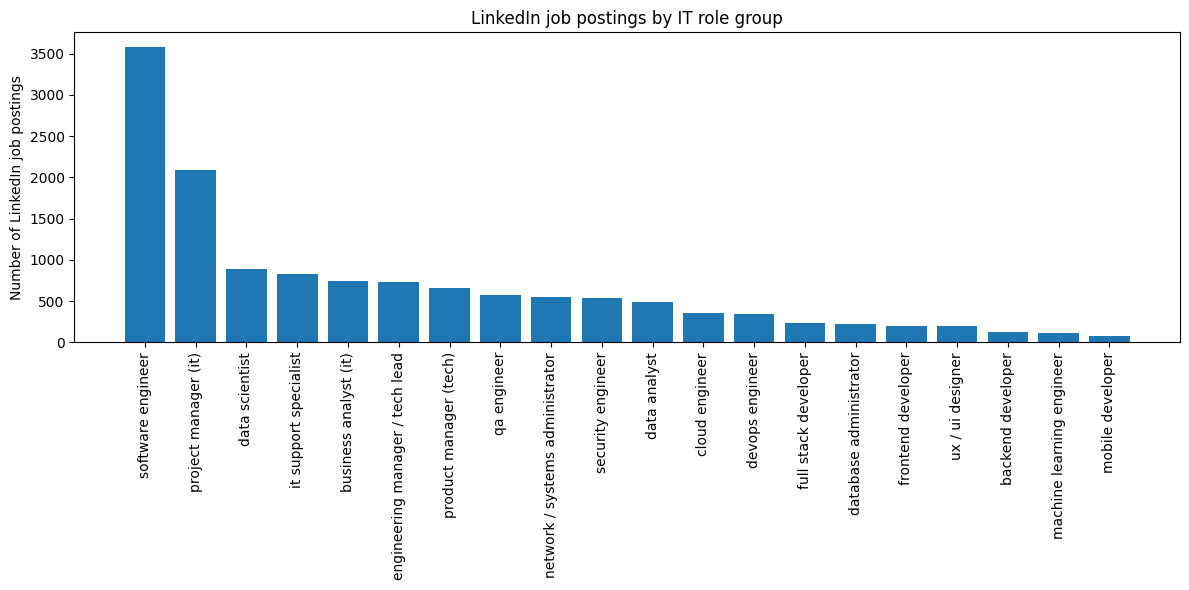

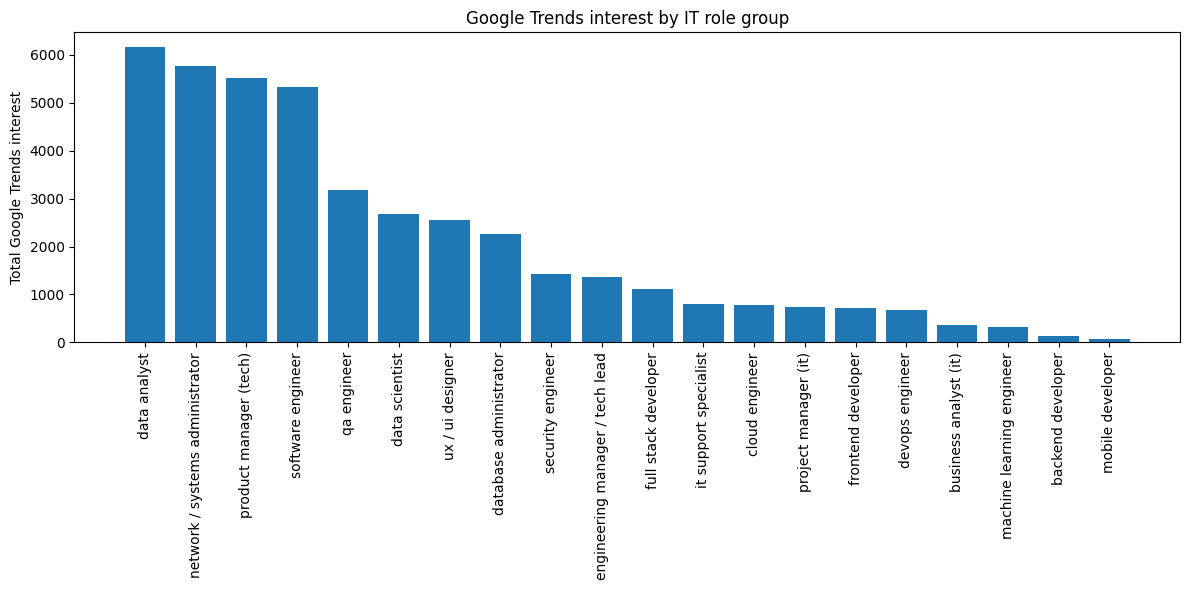

Rank comparison table (sorted by absolute rank difference):
                      it_role_group  count  total_trends_interest  \
1              project manager (it)   2085                    731   
4             business analyst (it)    744                    368   
10                     data analyst    488                   6164   
16                 ux / ui designer    198                   2557   
3             it support specialist    833                    809   
8   network / systems administrator    554                   5774   
14           database administrator    225                   2262   
5   engineering manager / tech lead    729                   1355   
6            product manager (tech)    659                   5511   
0                 software engineer   3578                   5339   
2                    data scientist    889                   2676   
7                       qa engineer    573                   3187   
13             full stack developer    231 

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

#
# 1. Read both datasets
#
linkedin = pd.read_csv("it_role_group_counts.csv")
trends = pd.read_csv("google_trends_it_jobs_totals_sorted.csv")

# Drop "other it" from LinkedIn if present (not in Trends)
linkedin = linkedin[linkedin["it_role_group"] != "other it"].copy()

#
# 2. BAR PLOT 1 - LinkedIn job posting counts
#
linkedin_plot = linkedin.sort_values("count", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(linkedin_plot["it_role_group"], linkedin_plot["count"])
plt.xticks(rotation=90)
plt.ylabel("Number of LinkedIn job postings")
plt.title("LinkedIn job postings by IT role group")
plt.tight_layout()
plt.show()

#
# 3. BAR PLOT 2 - Google Trends total interest
#
trends_plot = trends.sort_values("total_trends_interest", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(trends_plot["job_group"], trends_plot["total_trends_interest"])
plt.xticks(rotation=90)
plt.ylabel("Total Google Trends interest")
plt.title("Google Trends interest by IT role group")
plt.tight_layout()
plt.show()

#
# 4. RANK COMPARISON TABLE
#    Merge, compute ranks, rank differences
#
merged = pd.merge(
    linkedin,
    trends,
    left_on="it_role_group",
    right_on="job_group",
    how="inner"
)

# Compute ranks (1 = highest)
merged["linkedin_rank"] = merged["count"].rank(
    ascending=False, method="dense"
).astype(int)

merged["trends_rank"] = merged["total_trends_interest"].rank(
    ascending=False, method="dense"
).astype(int)

# Rank differences
merged["rank_diff"] = merged["linkedin_rank"] - merged["trends_rank"]
merged["abs_rank_diff"] = merged["rank_diff"].abs()

rank_table = merged[
    [
        "it_role_group",
        "count",
        "total_trends_interest",
        "linkedin_rank",
        "trends_rank",
        "rank_diff",
        "abs_rank_diff",
    ]
].sort_values("abs_rank_diff", ascending=False)

# Save to CSV for the report
rank_table.to_csv("job_group_rank_comparison.csv", index=False)

print("Rank comparison table (sorted by absolute rank difference):")
print(rank_table)


**Step 10 – Create scatter plots to compare demand and interest**

In this cell we first merge the LinkedIn and Google Trends datasets for the common IT role groups.  

Then we make two scatter plots:
1. A scatter plot of `count` (LinkedIn job postings) vs `total_trends_interest` (Google search interest), with labels for each IT role. This shows the overall relationship between demand and search interest.
2. A rank-based scatter plot, where each point is the LinkedIn rank vs the Google Trends rank for a role. We also draw the diagonal line `y = x`.  
   Roles close to the line have similar ranks in both datasets, while roles far from the line show a stronger mismatch between job demand and search interest.


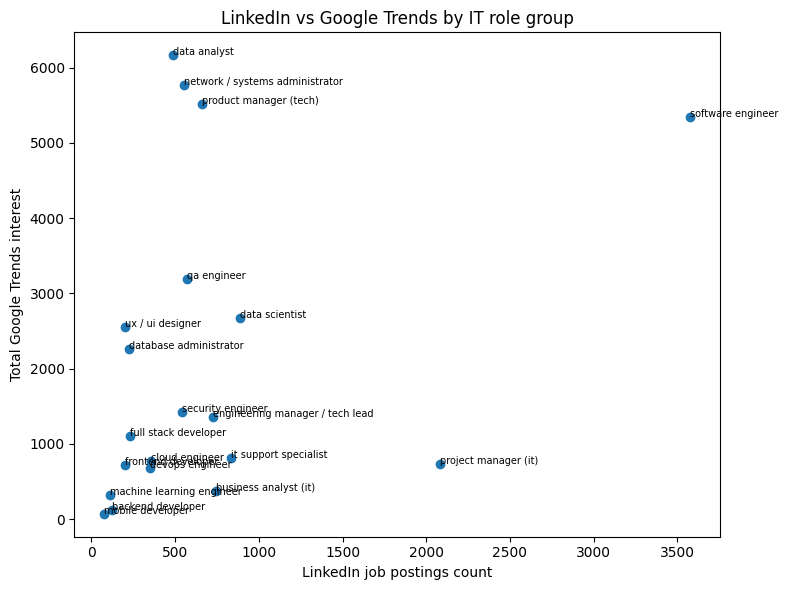

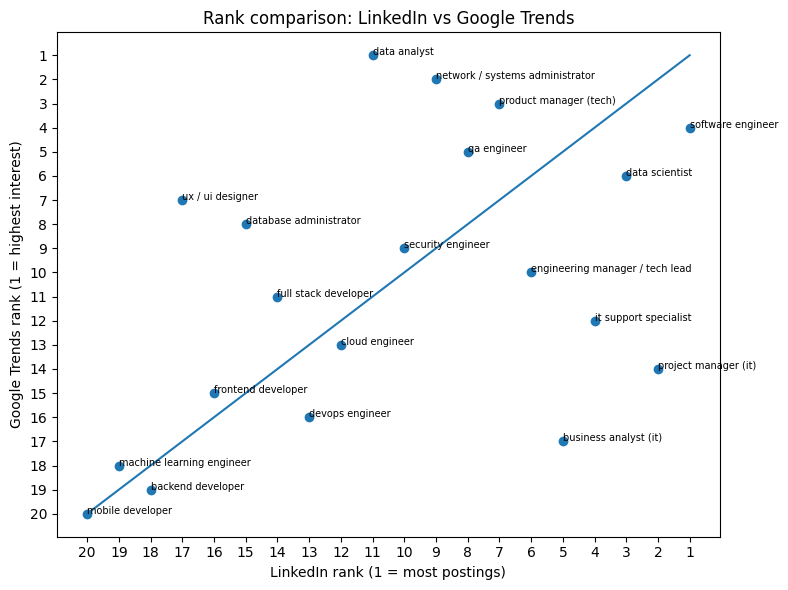

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

#
# 1. Read and merge datasets
#
linkedin = pd.read_csv("it_role_group_counts.csv")
trends = pd.read_csv("google_trends_it_jobs_totals_sorted.csv")

# Drop "other it" if present
linkedin = linkedin[linkedin["it_role_group"] != "other it"].copy()

merged = pd.merge(
    linkedin,
    trends,
    left_on="it_role_group",
    right_on="job_group",
    how="inner"
)

#
# 2. Scatter: LinkedIn count vs Trends interest
#
plt.figure(figsize=(8, 6))
plt.scatter(merged["count"], merged["total_trends_interest"])

for _, row in merged.iterrows():
    plt.text(
        row["count"],
        row["total_trends_interest"],
        row["it_role_group"],
        fontsize=7
    )

plt.xlabel("LinkedIn job postings count")
plt.ylabel("Total Google Trends interest")
plt.title("LinkedIn vs Google Trends by IT role group")
plt.tight_layout()
plt.show()

#
# 3. Rank-based scatter: LinkedIn rank vs Trends rank
#
merged["linkedin_rank"] = merged["count"].rank(
    ascending=False, method="dense"
).astype(int)

merged["trends_rank"] = merged["total_trends_interest"].rank(
    ascending=False, method="dense"
).astype(int)

plt.figure(figsize=(8, 6))
plt.scatter(merged["linkedin_rank"], merged["trends_rank"])

for _, row in merged.iterrows():
    plt.text(
        row["linkedin_rank"],
        row["trends_rank"],
        row["it_role_group"],
        fontsize=7
    )

# ideal line y = x
min_rank = min(merged["linkedin_rank"].min(), merged["trends_rank"].min())
max_rank = max(merged["linkedin_rank"].max(), merged["trends_rank"].max())
plt.plot([min_rank, max_rank], [min_rank, max_rank])

plt.xlabel("LinkedIn rank (1 = most postings)")
plt.ylabel("Google Trends rank (1 = highest interest)")
plt.title("Rank comparison: LinkedIn vs Google Trends")
plt.xticks(range(min_rank, max_rank + 1))
plt.yticks(range(min_rank, max_rank + 1))
plt.gca().invert_xaxis()  # optional: smaller rank to the left
plt.gca().invert_yaxis()  # optional: smaller rank to the top
plt.tight_layout()
plt.show()
